
| dataframe      | Description |due|
| ----------- | ----------- |----------- |
| tomato   |토마토 가격/거래량 + 부산 날씨   +  소비자 물가지수 + 유가     |20190101 ~ 20200928|
| grape   | 캠벨얼리 가격/거래량 + 남원 날씨   +  소비자 물가지수 + 유가    |20190101 ~ 20200928|
| shinemuscat   |샤인마스캇  가격/거래량 + 구미 날씨   +  소비자 물가지수 + 유가          |20190101 ~ 20200928|
| train   |   tomato +  grape +  shinemuscat   | 20190101 ~ 20200928|
| test   |   tomato +  grape +  shinemuscat   | 20200929 ~ 20200928|
| df     | train + test       | 20190101 ~ 20201105|

# 샤인머스캇 예시

In [48]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'

from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib as mpl
from IPython.core.display import display, HTML
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import urllib.request
import requests
import json
import datetime
import os
from datetime import datetime
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_path = '/Users/cge/Documents/yeardream/프로젝트/기업프로젝트/products_price_predict/data/raw/'
processed_path = '/Users/cge/Documents/yeardream/프로젝트/기업프로젝트/products_price_predict/data/processed/'

In [3]:
tomato = pd.read_csv(processed_path+'tomato.csv')
grape = pd.read_csv(processed_path+'grape.csv')
shinemuscat = pd.read_csv(processed_path+'shinemuscat.csv')

train = pd.read_csv(raw_path+'train.csv')
test = pd.read_csv(raw_path+'test.csv')
private = pd.read_csv(raw_path+'private_data.csv')
submission = pd.read_csv(raw_path+'sample_submission.csv')


print(train.shape)
print(test.shape)
print(private.shape)
print(submission.shape)

(1733, 44)
(37, 44)
(291, 44)
(228, 22)


In [4]:
tomato.drop(columns=[ '고급휘발유', '보통휘발유', '실내등유' ], inplace=True )
grape.drop(columns=[ '고급휘발유',  '보통휘발유', '실내등유' ], inplace=True )
shinemuscat.drop(columns=[ '고급휘발유', '보통휘발유','실내등유' ], inplace=True )

## 정규화

In [5]:
robust_shinemuscat = shinemuscat[['샤인마스캇_거래량(kg)','소비자물가지수', '자동차용경유',
       '평균기온', '최고기온', '최저기온', '평균운량', '일강수량', '일교차']]

In [50]:
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler()
robust_scaler = robust_scaler.fit_transform(robust_shinemuscat)
shinemuscat_scaler = pd.DataFrame(robust_scaler, columns=robust_shinemuscat.columns)
shinemuscat_scaler.head()

샤인마스캇_거래량(kg)   소비자물가지수    자동차용경유      평균기온      최고기온      최저기온  평균운량  \
0      -0.045291 -1.704941 -0.741484 -0.864706 -0.794118 -0.841808   0.0   
1      -0.045291 -1.704941 -0.747138 -0.764706 -0.635294 -0.723164   0.0   
2      -0.045291 -1.704941 -0.752862 -0.682353 -0.470588 -0.689266   0.0   
3      -0.045291 -1.704941 -0.761696 -0.517647 -0.594118 -0.406780   0.0   
4      -0.045291 -1.704941 -0.774700 -0.788235 -0.952941 -0.593220   0.0   

   일강수량       일교차  
0   0.0  0.470588  
1   0.0  0.588235  
2   0.0  1.019608  
3   0.0 -0.372549  
4   0.0 -0.921569

## 모델링
성능을 알아보기 위한 모델 <br> 샤인머스캇 가격을 예측

In [25]:
# 2020년08월31일까지 train, 2020년09월01일부터 test

split = 28
target = shinemuscat['샤인마스캇_가격(원/kg)']

shinemuscat = pd.concat([target, shinemuscat_scaler],axis = 1)
feature = ['샤인마스캇_거래량(kg)', '소비자물가지수', '자동차용경유', '평균기온', '최고기온',
       '최저기온', '평균운량', '일강수량', '일교차']
    
shinemuscat_learn = shinemuscat[:-split]
shinemuscat_predict = shinemuscat[-split:]

X_train = shinemuscat_learn[feature]
y_train = shinemuscat_learn['샤인마스캇_가격(원/kg)']
X_test = shinemuscat_predict[feature]
y_test = shinemuscat_predict['샤인마스캇_가격(원/kg)']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1705, 9) (1705,) (28, 9) (28,)


### 모델의 예측 결과
전반적인 추세는 잘 예측하지만 거래가 발생하지 않는 일요일 전후로 예측 성능이 떨어지는 모습을 보임

큰 폭으로 변동되는 가격은 잘 예측 하지 못함(뾰족뾰족한 부분)

[모델링참고](https://github.com/seongmoonKang/Data-Analysis-Capstone)

###  RandomForest

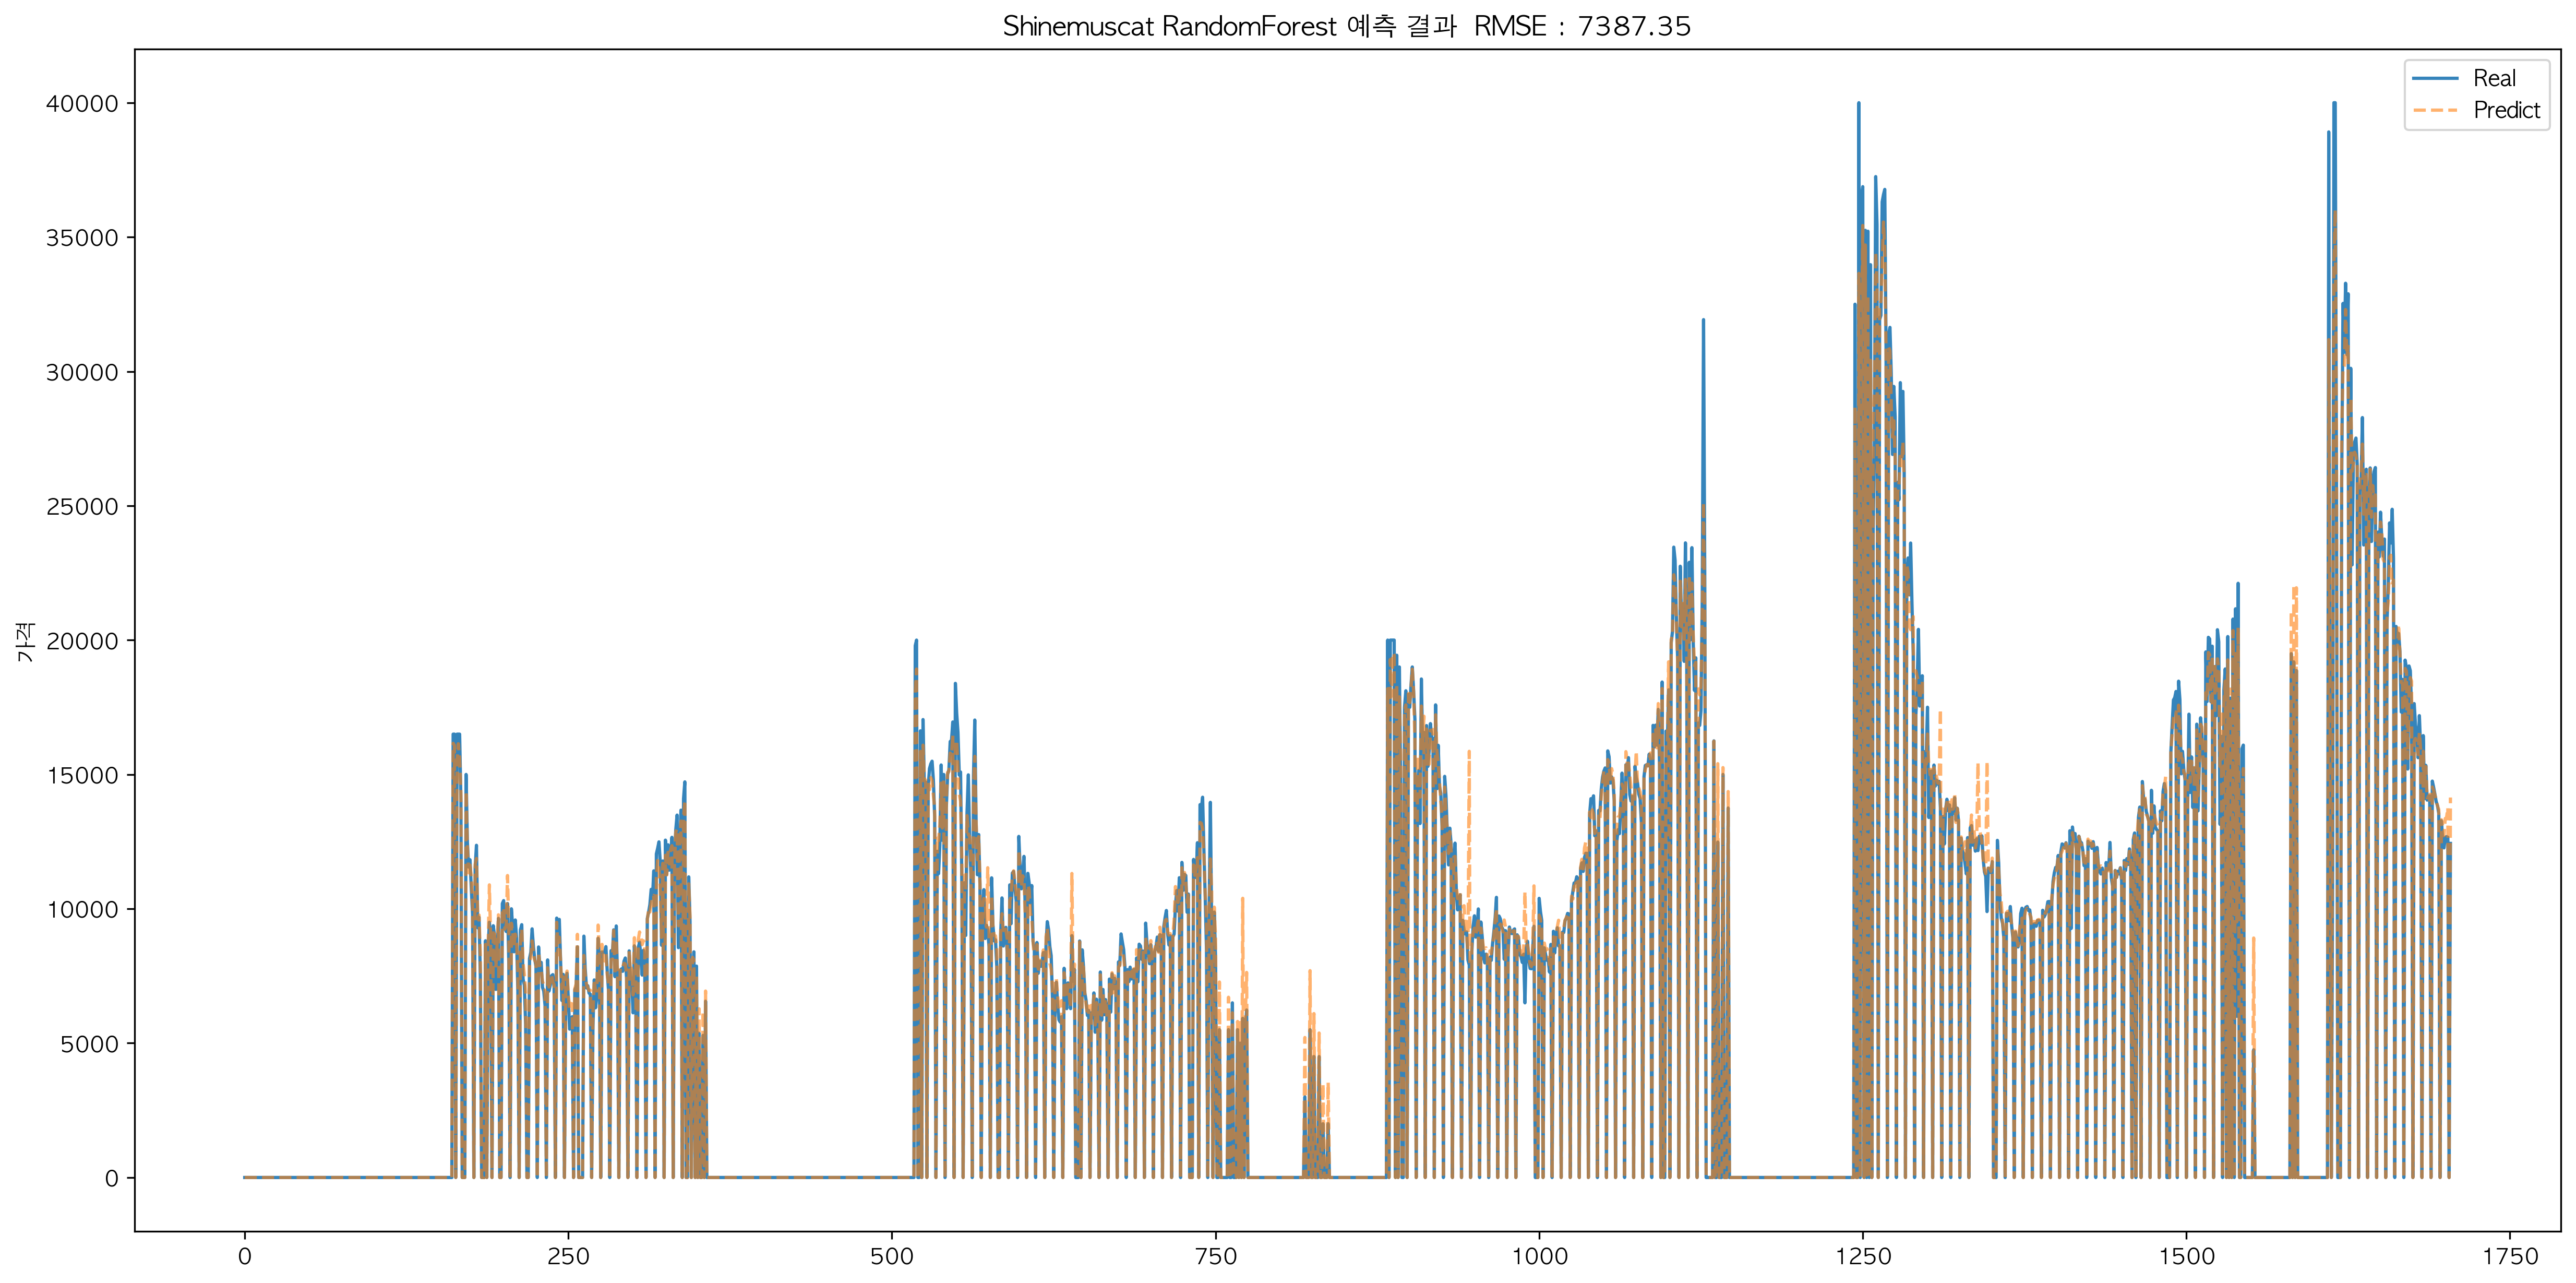

In [49]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1, random_state=0)
model.fit(X_train, y_train)

# metrics
y_pred = model.predict(X_test)
RMSE = (mean_squared_error(y_test, y_pred) ** 0.5)
# MAE = mean_absolute_error(y_test, y_pred)

plt.figure(figsize=(20, 10), dpi=300)
plt.title('Shinemuscat RandomForest 예측 결과'+ '  RMSE : ' + str(RMSE)[:7])
plt.ylabel('가격')
plt.plot(np.array(y_train), alpha = 0.9, label = 'Real')
plt.plot(model.predict(X_train), alpha = 0.6, linestyle = "--", label = 'Predict')
plt.legend()
plt.show()

In [33]:
# RMSE
np.sum(np.sqrt((y_test - y_pred)**2/len(y_test)))

50684.05570491758

### XGBoost

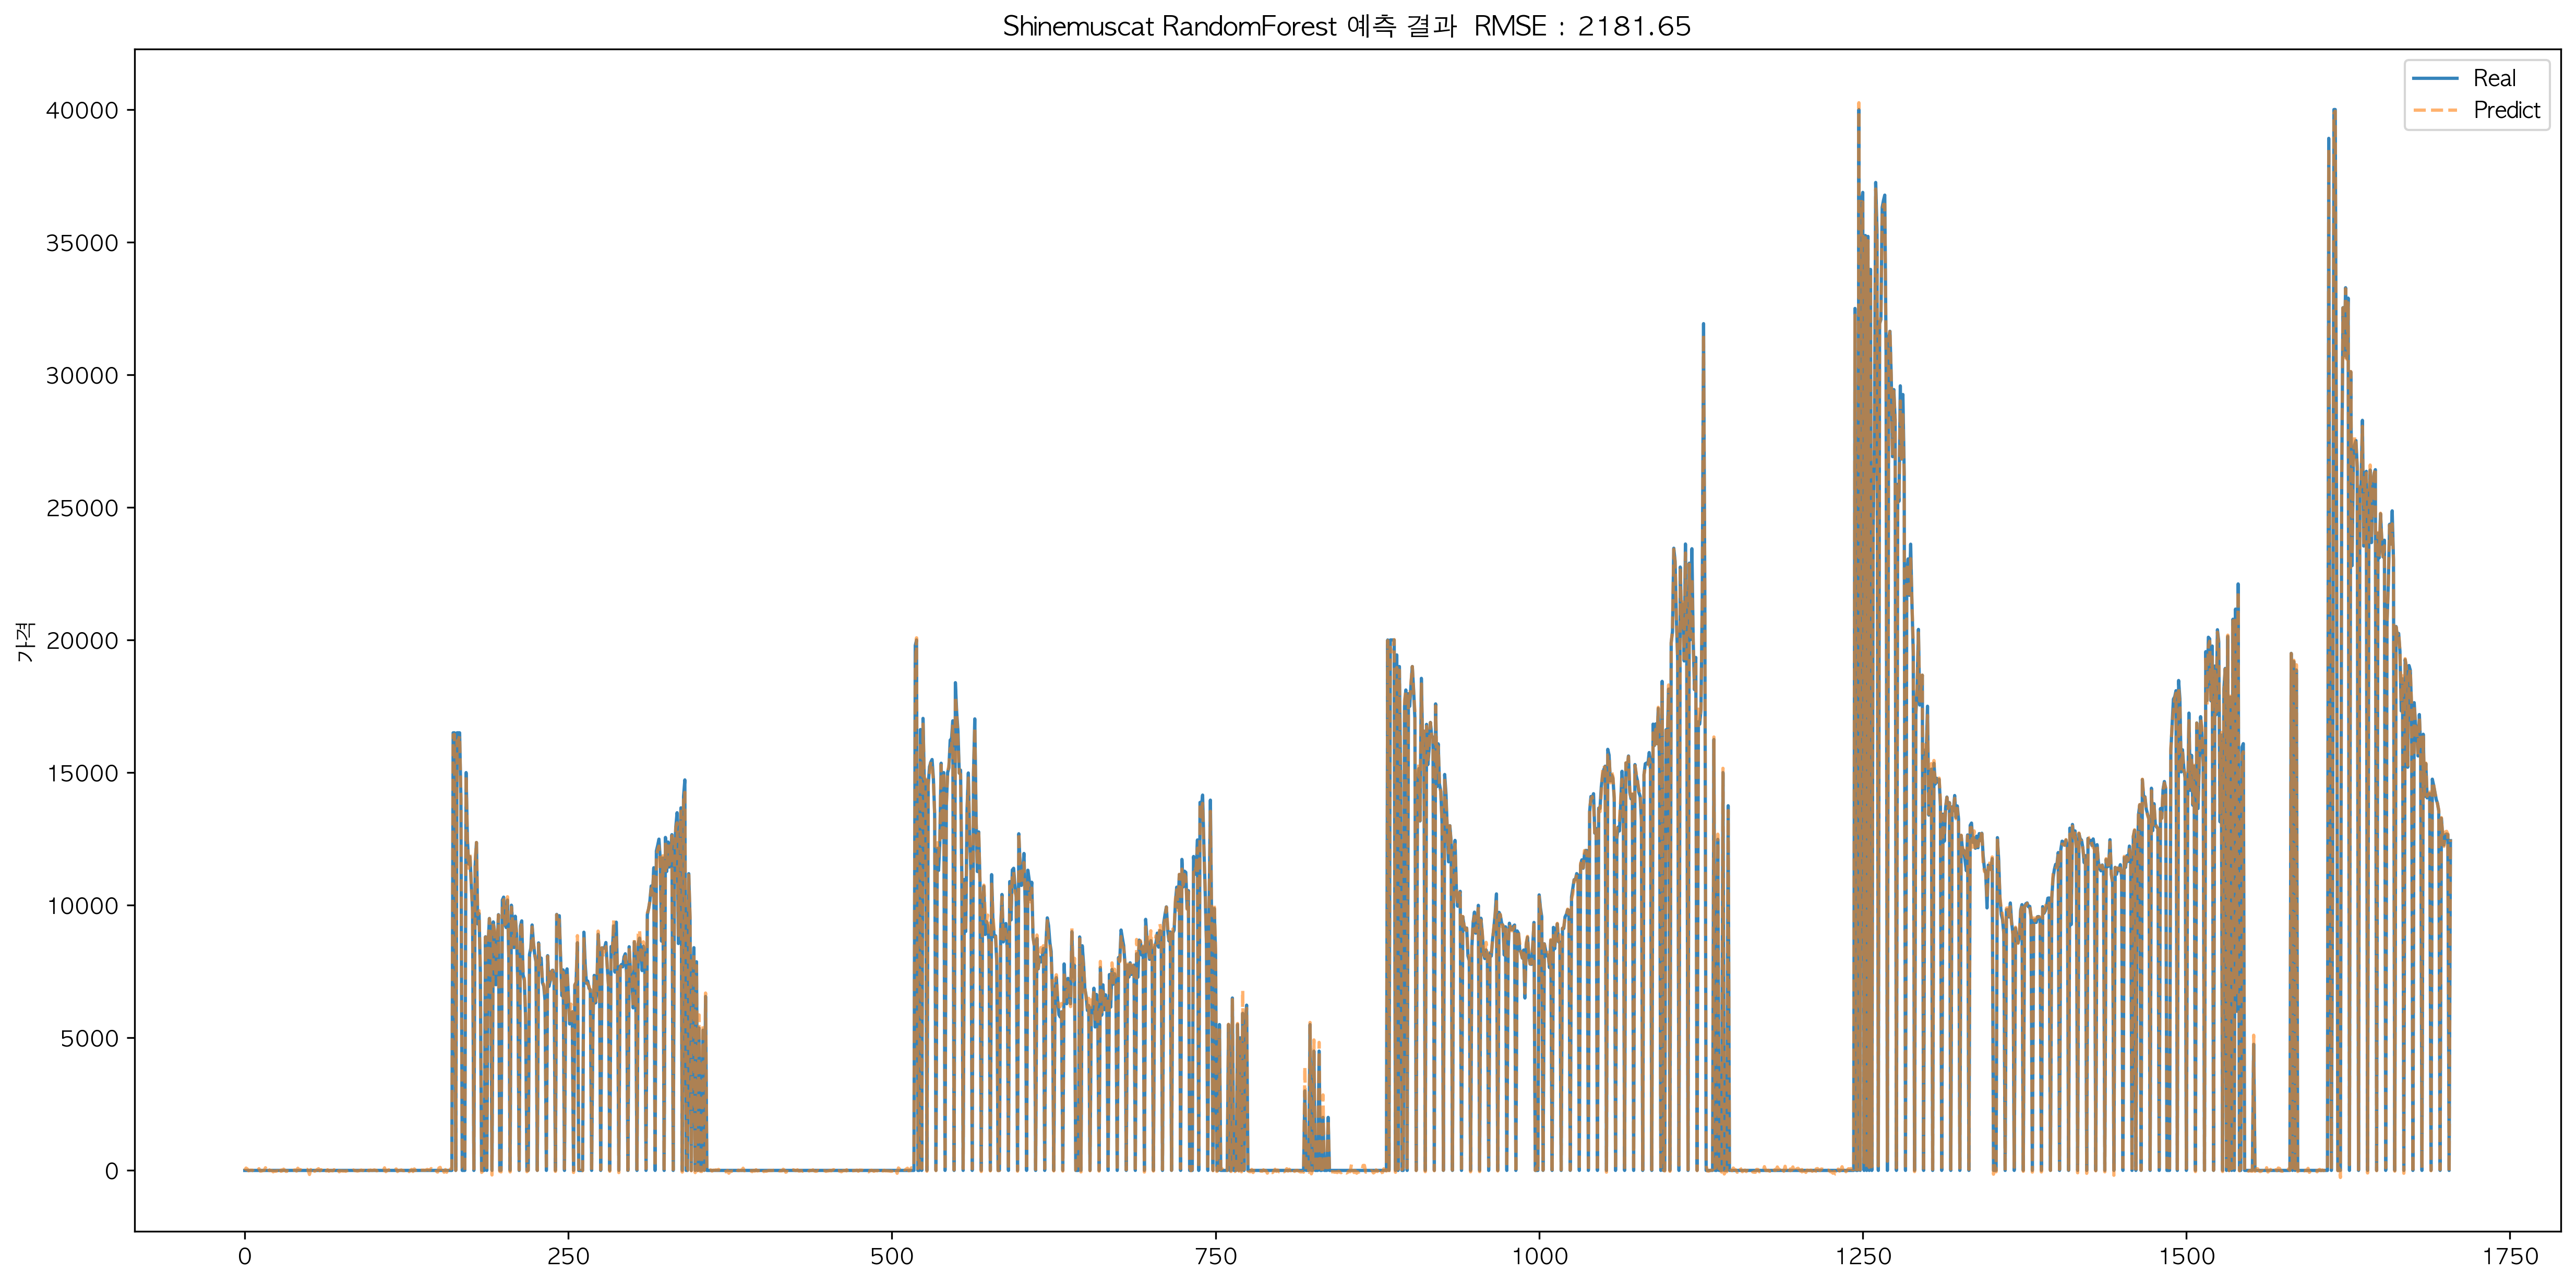

In [35]:
import xgboost as xgb

model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# metrics
y_pred = model.predict(X_test)
RMSE = (mean_squared_error(y_test, y_pred) ** 0.5)
# MAE = mean_absolute_error(y_test, y_pred)

plt.figure(figsize=(20, 10), dpi=300)
plt.title('Shinemuscat RandomForest 예측 결과'+ '  RMSE : ' + str(RMSE)[:7])
plt.ylabel('가격')
plt.plot(np.array(y_train), alpha = 0.9, label = 'Real')
plt.plot(model.predict(X_train), alpha = 0.6, linestyle = "--", label = 'Predict')
plt.legend()
plt.show()

### LightGBM
```
params = {'learning_rate': 0.01, 
          'max_depth': 6, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 100, 
          'feature_fraction': 0.8, 
          'bagging_fraction': 0.8, 
          'bagging_freq': 5, 
          'seed':42,
          'num_threads':8
             }
```

In [29]:
import lightgbm as lgb

def init_score(y):
    return y - np.mean(y)

In [42]:
train_set = lgb.Dataset(data = X_train,  label = y_train)
test_set = lgb.Dataset(data = X_test,  label = y_test)

In [45]:
params = {
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

model = lgb.train(params, 
                   train_set,
                   10000,
                   test_set,
                   verbose_eval = 100, 
                   early_stopping_rounds = 100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1757
[LightGBM] [Info] Number of data points in the train set: 1705, number of used features: 9
[LightGBM] [Info] Start training from score 6930.746628
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 6601.71
Early stopping, best iteration is:
[6]	valid_0's l1: 883.893


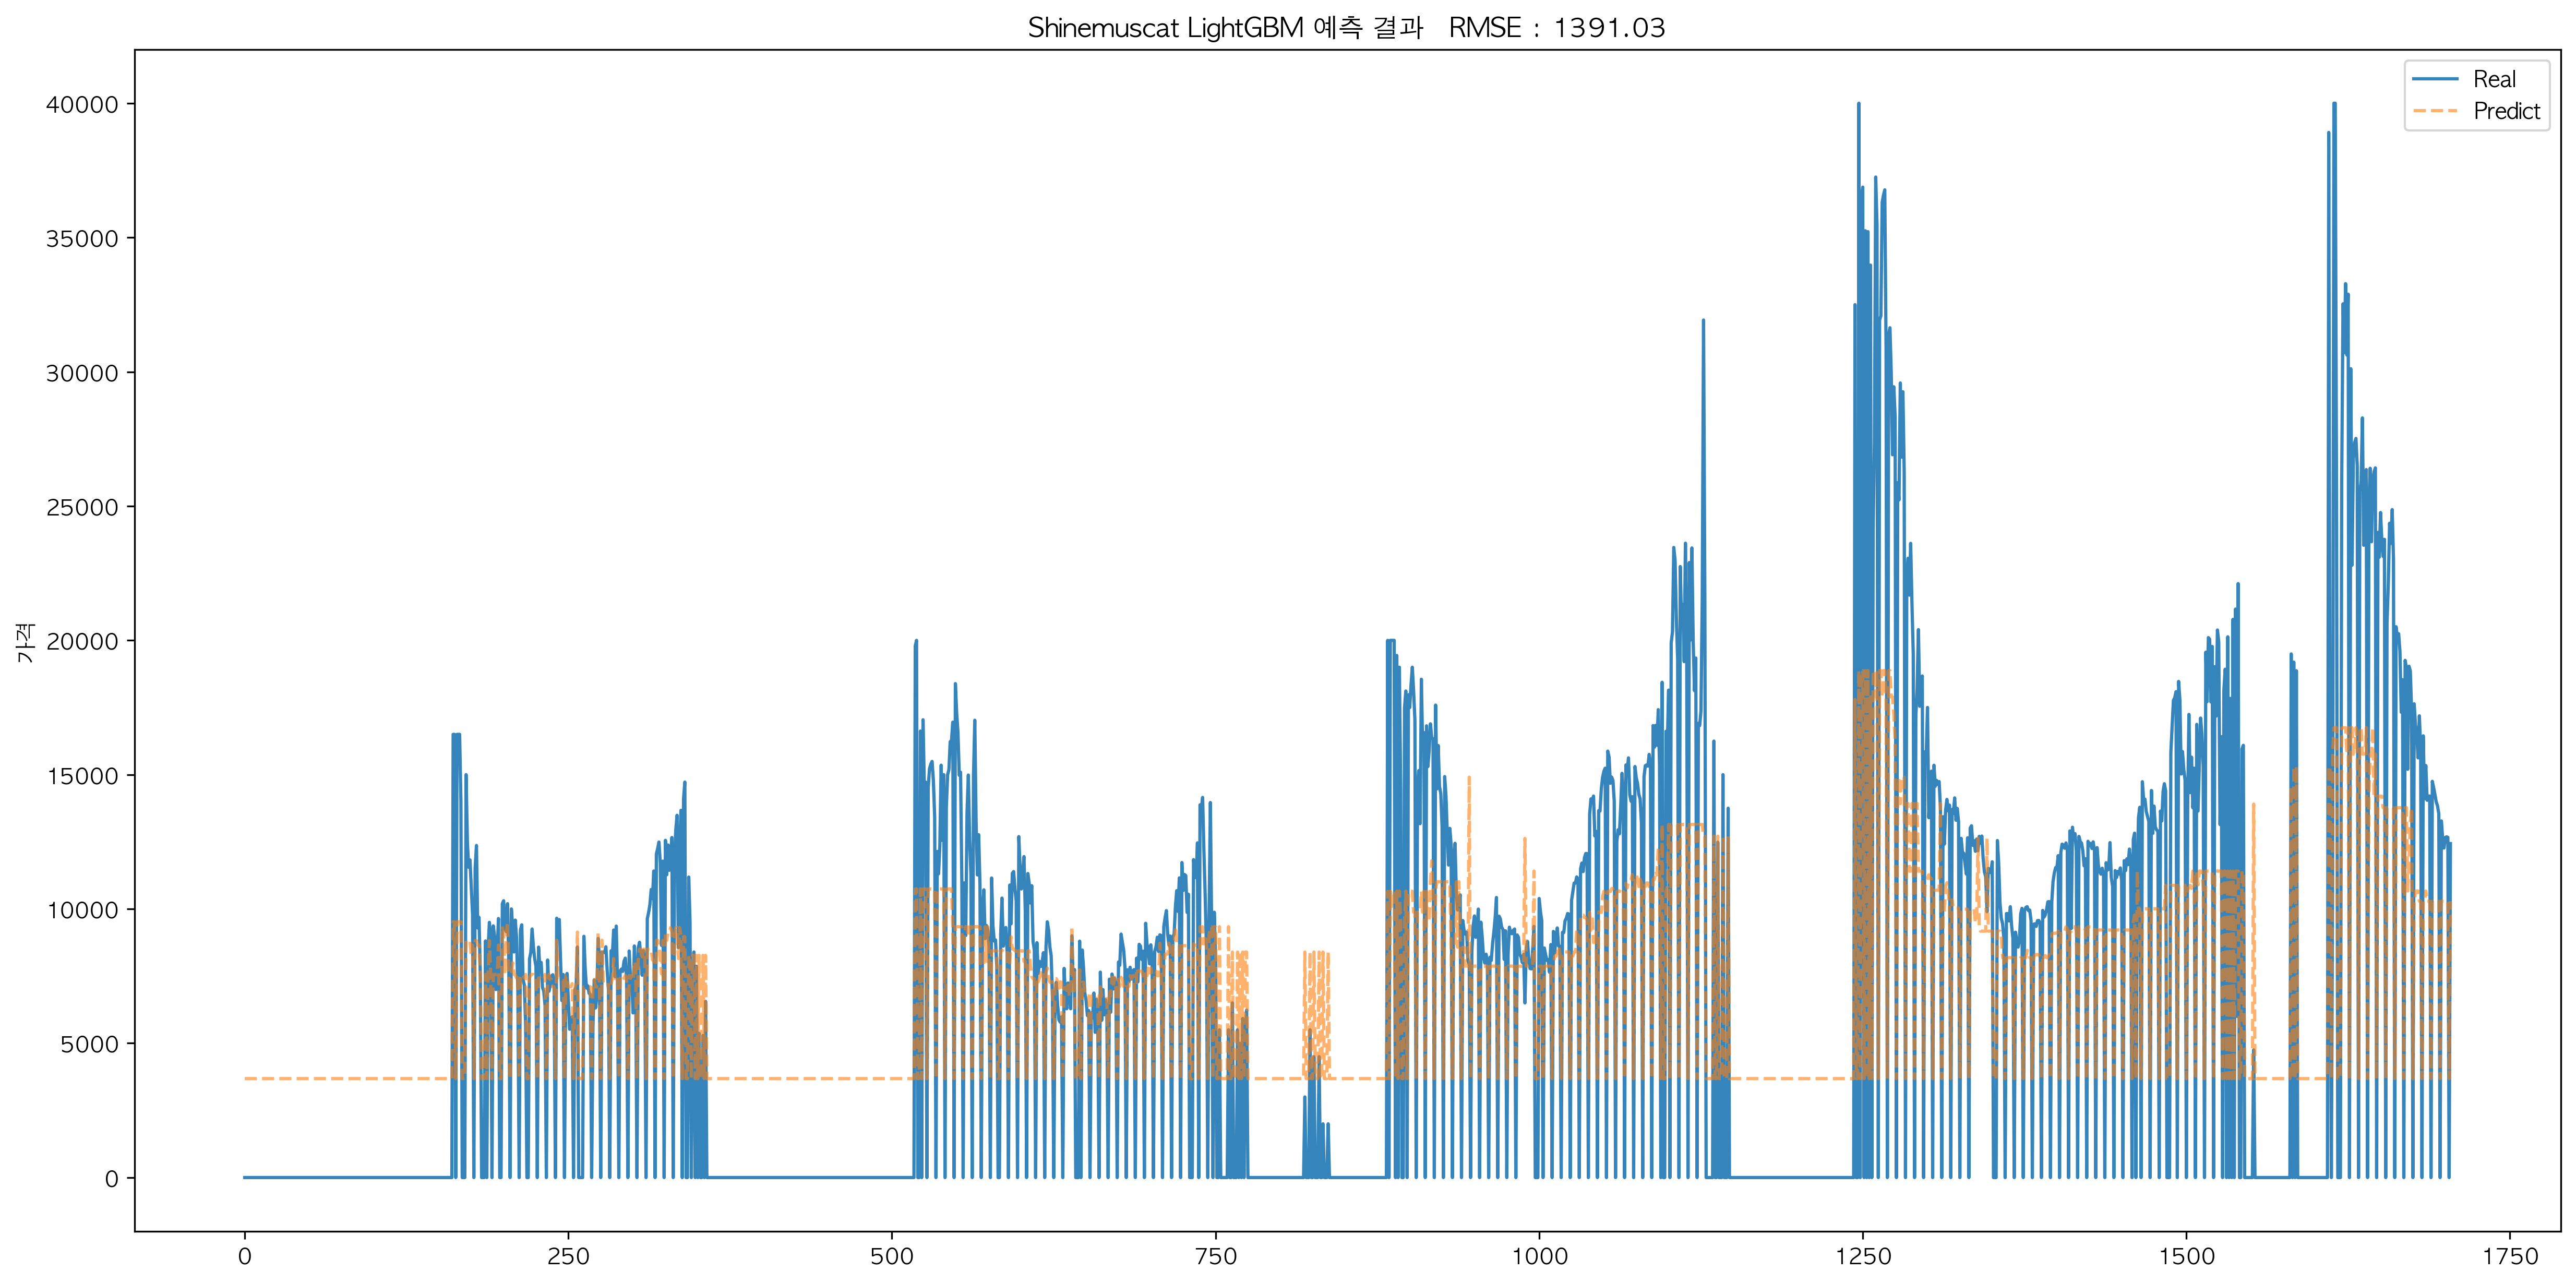

In [46]:
# metrics
y_pred = model.predict(X_test)
RMSE = (mean_squared_error(y_test, y_pred) ** 0.5)
# np.sqrt(mean_squared_error(y_test, y_pred))

plt.figure(figsize=(20, 10), dpi=300)
plt.title('Shinemuscat LightGBM 예측 결과'+   '   RMSE : ' + str(RMSE)[:7])
plt.ylabel('가격')
plt.plot(np.array(y_train), alpha = 0.9, label = 'Real')
plt.plot(model.predict(X_train), alpha = 0.6, linestyle = "--", label = 'Predict')
plt.legend()
plt.show()

### LSTM

In [20]:
import tensorflow as tf
import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from statsmodels.tsa.seasonal import seasonal_decompose, STL

shinemuscat = pd.concat([target, shinemuscat_scaler],axis = 1)
target = shinemuscat['샤인마스캇_가격(원/kg)']
feature = ['샤인마스캇_거래량(kg)', '소비자물가지수', '자동차용경유', '평균기온', '최고기온',
       '최저기온', '평균운량', '일강수량', '일교차']

    
# 2020년08월31일까지 train, 2020년09월01일부터 test
split = 28
target = shinemuscat['샤인마스캇_가격(원/kg)']
shinemuscat_learn = shinemuscat[:-split]
shinemuscat_predict = shinemuscat[-split:]

X_train = shinemuscat_learn[feature].values.reshape(-1,1,len(feature))
y_train = shinemuscat_learn['샤인마스캇_가격(원/kg)'].values.reshape(-1,1,1)
X_test = shinemuscat_predict[feature].values.reshape(-1,1,len(feature))
y_test = shinemuscat_predict['샤인마스캇_가격(원/kg)'].values.reshape(-1,1,1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [25]:
model = Sequential()
model.add(layers.Activation('relu'))
model.add(tf.compat.v1.keras.layers.LSTM(100, input_shape=(21,len(feature)), return_sequences=True))
model.add(Dropout(0.1))
model.add(layers.Dense(30))
model.add(Dropout(0.1))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(patience=30)
model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split = 0.1, callbacks=[early_stopping], verbose=1)

Epoch 1/1000


2022-10-05 16:22:27.161684: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


48/48 [==============================] - 1s 4ms/step - loss: 95581824.0000 - val_loss: 253028288.0000
Epoch 2/1000
48/48 [==============================] - 0s 1ms/step - loss: 95414608.0000 - val_loss: 252318656.0000
Epoch 3/1000
48/48 [==============================] - 0s 2ms/step - loss: 94830272.0000 - val_loss: 250408224.0000
Epoch 4/1000
48/48 [==============================] - 0s 2ms/step - loss: 93674648.0000 - val_loss: 247562784.0000
Epoch 5/1000
48/48 [==============================] - 0s 2ms/step - loss: 91988928.0000 - val_loss: 243904416.0000
Epoch 6/1000
48/48 [==============================] - 0s 2ms/step - loss: 89873224.0000 - val_loss: 239490912.0000
Epoch 7/1000
48/48 [==============================] - 0s 2ms/step - loss: 87460848.0000 - val_loss: 234468688.0000
Epoch 8/1000
48/48 [==============================] - 0s 2ms/step - loss: 84650912.0000 - val_loss: 229185808.0000
Epoch 9/1000
48/48 [==============================] - 0s 2ms/step - loss: 81804720.0000 - val

Epoch 72/1000
48/48 [==============================] - 0s 1ms/step - loss: 27759914.0000 - val_loss: 99747544.0000
Epoch 73/1000
48/48 [==============================] - 0s 1ms/step - loss: 27956858.0000 - val_loss: 98736816.0000
Epoch 74/1000
48/48 [==============================] - 0s 1ms/step - loss: 27713242.0000 - val_loss: 98761480.0000
Epoch 75/1000
48/48 [==============================] - 0s 1ms/step - loss: 27885408.0000 - val_loss: 98510944.0000
Epoch 76/1000
48/48 [==============================] - 0s 1ms/step - loss: 28066256.0000 - val_loss: 98760672.0000
Epoch 77/1000
48/48 [==============================] - 0s 2ms/step - loss: 28160234.0000 - val_loss: 98767704.0000
Epoch 78/1000
48/48 [==============================] - 0s 2ms/step - loss: 27897686.0000 - val_loss: 98657120.0000
Epoch 79/1000
48/48 [==============================] - 0s 2ms/step - loss: 27778090.0000 - val_loss: 98588984.0000
Epoch 80/1000
48/48 [==============================] - 0s 2ms/step - loss: 27404

Epoch 143/1000
48/48 [==============================] - 0s 2ms/step - loss: 24072338.0000 - val_loss: 91989976.0000
Epoch 144/1000
48/48 [==============================] - 0s 2ms/step - loss: 24321466.0000 - val_loss: 92421752.0000
Epoch 145/1000
48/48 [==============================] - 0s 2ms/step - loss: 23837852.0000 - val_loss: 90925920.0000
Epoch 146/1000
48/48 [==============================] - 0s 2ms/step - loss: 23938290.0000 - val_loss: 91249816.0000
Epoch 147/1000
48/48 [==============================] - 0s 2ms/step - loss: 23988944.0000 - val_loss: 92188592.0000
Epoch 148/1000
48/48 [==============================] - 0s 2ms/step - loss: 23932856.0000 - val_loss: 92243608.0000
Epoch 149/1000
48/48 [==============================] - 0s 2ms/step - loss: 23608564.0000 - val_loss: 90982384.0000
Epoch 150/1000
48/48 [==============================] - 0s 1ms/step - loss: 23896270.0000 - val_loss: 90811040.0000
Epoch 151/1000
48/48 [==============================] - 0s 2ms/step - lo

Epoch 284/1000
48/48 [==============================] - 0s 2ms/step - loss: 18832182.0000 - val_loss: 77747600.0000
Epoch 285/1000
48/48 [==============================] - 0s 2ms/step - loss: 18845706.0000 - val_loss: 77652384.0000
Epoch 286/1000
48/48 [==============================] - 0s 2ms/step - loss: 18860918.0000 - val_loss: 77147728.0000
Epoch 287/1000
48/48 [==============================] - 0s 2ms/step - loss: 18672942.0000 - val_loss: 77840728.0000
Epoch 288/1000
48/48 [==============================] - 0s 2ms/step - loss: 18948538.0000 - val_loss: 76891744.0000
Epoch 289/1000
48/48 [==============================] - 0s 2ms/step - loss: 18872966.0000 - val_loss: 76950376.0000
Epoch 290/1000
48/48 [==============================] - 0s 2ms/step - loss: 18870884.0000 - val_loss: 77920152.0000
Epoch 291/1000
48/48 [==============================] - 0s 2ms/step - loss: 18914468.0000 - val_loss: 76536568.0000
Epoch 292/1000
48/48 [==============================] - 0s 1ms/step - lo

Epoch 425/1000
48/48 [==============================] - 0s 2ms/step - loss: 16669534.0000 - val_loss: 71082912.0000
Epoch 426/1000
48/48 [==============================] - 0s 2ms/step - loss: 16397149.0000 - val_loss: 70966016.0000
Epoch 427/1000
48/48 [==============================] - 0s 2ms/step - loss: 16495229.0000 - val_loss: 71761952.0000
Epoch 428/1000
48/48 [==============================] - 0s 2ms/step - loss: 17013356.0000 - val_loss: 70689424.0000
Epoch 429/1000
48/48 [==============================] - 0s 2ms/step - loss: 16915784.0000 - val_loss: 70563088.0000
Epoch 430/1000
48/48 [==============================] - 0s 1ms/step - loss: 16644330.0000 - val_loss: 70991240.0000
Epoch 431/1000
48/48 [==============================] - 0s 2ms/step - loss: 16716369.0000 - val_loss: 71514528.0000
Epoch 432/1000
48/48 [==============================] - 0s 1ms/step - loss: 16717082.0000 - val_loss: 71347416.0000
Epoch 433/1000
48/48 [==============================] - 0s 2ms/step - lo

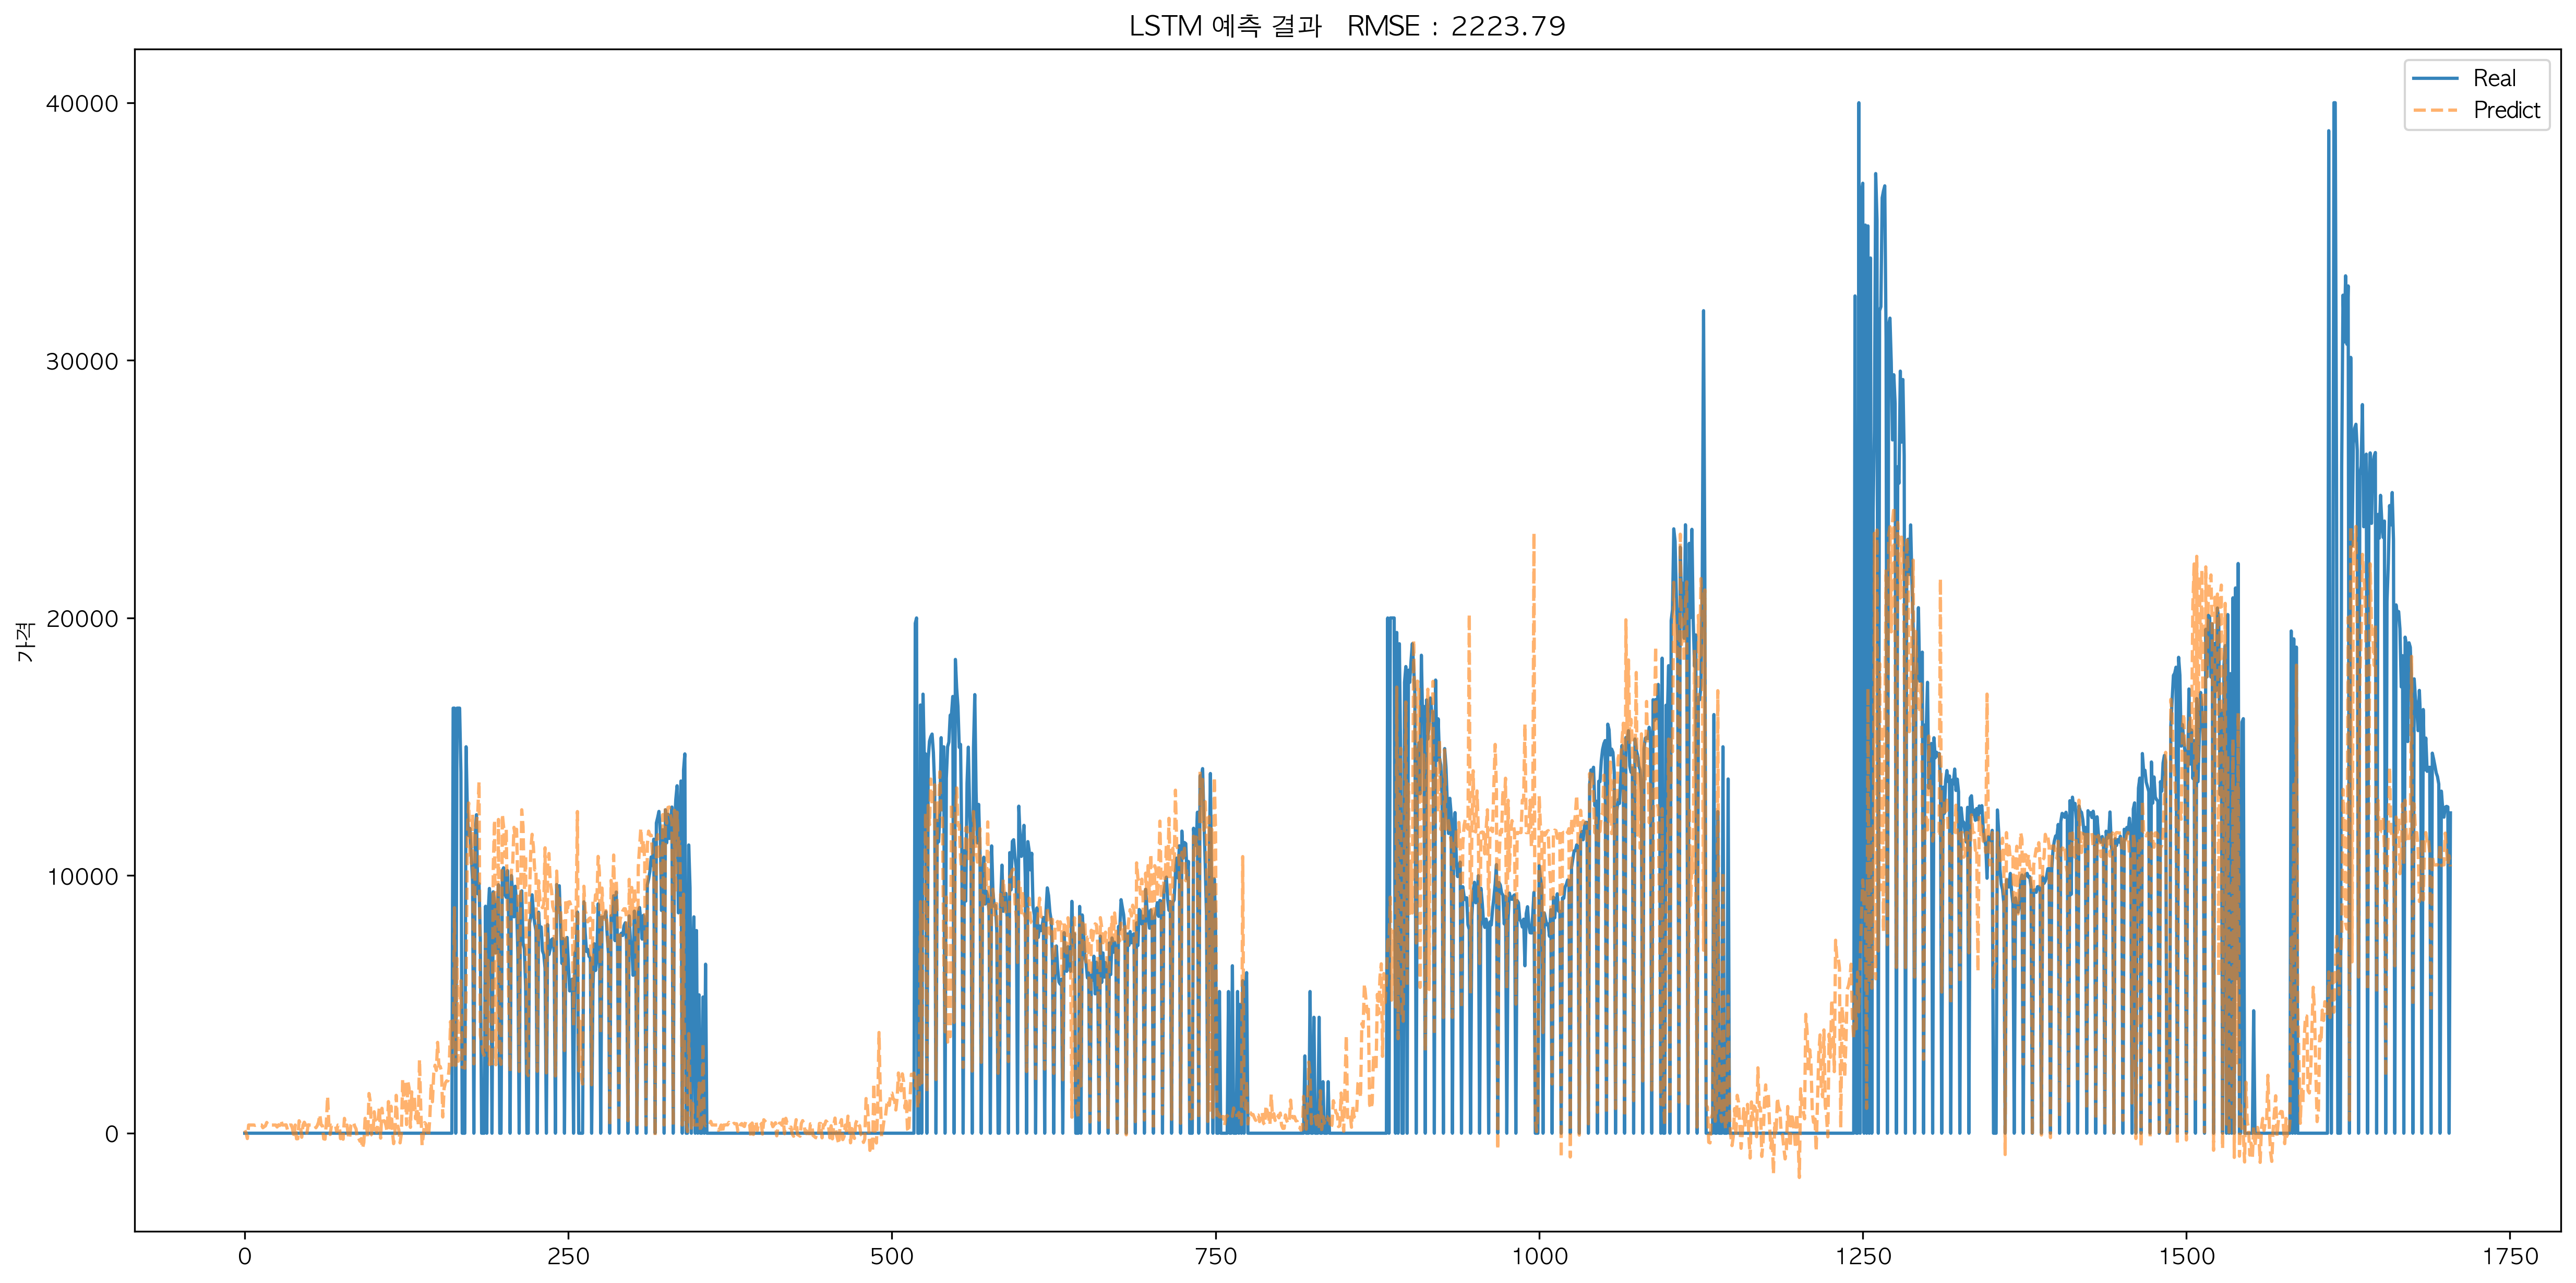

In [33]:
y_pred = model.predict(X_test)
RMSE = mean_squared_error(y_test.reshape(-1,1), y_pred.reshape(-1,1)) ** 0.5

plt.figure(figsize=(20, 10), dpi=300)
plt.title('LSTM 예측 결과'+   '   RMSE : ' + str(RMSE)[:7])
plt.ylabel('가격')
plt.plot(np.array(y_train.reshape(-1,1)), alpha = 0.9, label = 'Real')
plt.plot(model.predict(X_train).reshape(-1,1), alpha = 0.6, linestyle = "--", label = 'Predict')
plt.legend()
plt.show()